## Master Data Preparation for Statistical Analysis

This Jupyter notebook merges processed books and authors datasets, and prepares the master data for performing hypothesis testing, including basic data cleaning and feature generation.

#### Import Libraries

In [50]:
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns

#### Data Upload & Merge

In [51]:
books_path = "C:\\Users\\juhic\\OneDrive\\Desktop\\books_processed.csv"
authors_path = "C:\\Users\\juhic\\OneDrive\\Desktop\\authors_processed.csv"
books = pd.read_csv(books_path)
authors = pd.read_csv(authors_path)

books.drop(columns = 'Unnamed: 0', axis = 1, inplace = True)
authors.drop(columns = 'Unnamed: 0', axis = 1, inplace = True)

data = pd.merge(left = books, right = authors, how = 'inner', on = 'author')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35121 entries, 0 to 35120
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   35121 non-null  int64  
 1   title                35121 non-null  object 
 2   series               17959 non-null  object 
 3   author               35121 non-null  object 
 4   rating_count         35121 non-null  int64  
 5   review_count         35121 non-null  int64  
 6   average_rating       35121 non-null  float64
 7   five_star_ratings    35121 non-null  int64  
 8   four_star_ratings    35121 non-null  int64  
 9   three_star_ratings   35121 non-null  int64  
 10  two_star_ratings     35121 non-null  int64  
 11  one_star_ratings     35121 non-null  int64  
 12  page_count           35121 non-null  float64
 13  published_year       35121 non-null  int64  
 14  genre                35121 non-null  object 
 15  is_volume            35121 non-null 

#### Dropping irrelevant columns

In [52]:
drop_cols = ['series',
             'review_count',
             'average_rating',
             'five_star_ratings',
             'four_star_ratings',
             'three_star_ratings',
             'two_star_ratings',
             'one_star_ratings',
             'published_year']
data.drop(axis = 1, columns = drop_cols, inplace = True)

data.rename(columns = {'id':'book_id',
                       'title':'book_name',
                       'author':'author_name',
                       'work_count':'author_work_count',
                       'fan_count':'author_fan_count',
                       'sex':'author_sex'}, inplace = True)

cols = ['book_id','book_name','genre','page_count','is_volume','rating_count',
        'author_name','author_sex','author_work_count','author_fan_count',
        'author_rating_count','author_review_count','author_avg_rating']
data = data[cols]
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35121 entries, 0 to 35120
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   book_id              35121 non-null  int64  
 1   book_name            35121 non-null  object 
 2   genre                35121 non-null  object 
 3   page_count           35121 non-null  float64
 4   is_volume            35121 non-null  object 
 5   rating_count         35121 non-null  int64  
 6   author_name          35121 non-null  object 
 7   author_sex           35121 non-null  object 
 8   author_work_count    35121 non-null  int64  
 9   author_fan_count     35121 non-null  int64  
 10  author_rating_count  35121 non-null  int64  
 11  author_review_count  35121 non-null  int64  
 12  author_avg_rating    35121 non-null  float64
dtypes: float64(2), int64(6), object(5)
memory usage: 3.8+ MB


#### Type Conversions

In [53]:
data['page_count'] = data['page_count'].astype(int)

#### Data Cleaning

In [54]:
data.head()

,book_id,book_name,genre,page_count,is_volume,rating_count,author_name,author_sex,author_work_count,author_fan_count,author_rating_count,author_review_count,author_avg_rating
0,630104,inner circle,young adult,220,yes,7597,kate brian,female,40,2192,182878,8604,3.93
1,1783289,ambition,young adult,279,yes,6719,kate brian,female,40,2192,182878,8604,3.93
2,2206960,revelation,young adult,249,yes,7431,kate brian,female,40,2192,182878,8604,3.93
3,1783281,legacy,young adult,243,yes,7010,kate brian,female,40,2192,182878,8604,3.93
4,7148778,vanished,young adult,204,yes,3724,kate brian,female,40,2192,182878,8604,3.93


In [55]:
# Fixing duplicate author information

x = data[['author_name','author_work_count']].drop_duplicates()
t = x['author_name'].value_counts()
t.head(10)

morgan parker       2
alexis hall         2
lee smith           2
robin hardy         2
j.a. baker          2
stephen r. covey    1
andrew grey         1
leonard mlodinow    1
john burnside       1
sabine durrant      1
Name: author_name, dtype: int64

In [56]:
i1 = data[(data['author_name'] == 'alexis hall') & (data['author_sex'] == 'female')].index
i2 = data[(data['author_name'] == 'j.a. baker') & (data['author_sex'] == 'male')].index
i3 = data[(data['author_name'] == 'morgan parker') & (data['author_sex'] == 'male')].index
i4 = data[(data['author_name'] == 'lee smith') & (data['author_sex'] == 'male')].index
i5 = data[(data['author_name'] == 'robin hardy') & (data['author_sex'] == 'female')].index

data.drop(axis = 0, index = i1, inplace = True)
data.drop(axis = 0, index = i2, inplace = True)
data.drop(axis = 0, index = i3, inplace = True)
data.drop(axis = 0, index = i4, inplace = True)
data.drop(axis = 0, index = i5, inplace = True)

In [57]:
# Removing non-book records (audiobooks, collections poetry etc.)
mask1 = data['page_count'] < 10
mask2 = data['page_count'] >= 5000
data.drop(axis = 0, index = data[mask1 | mask2].index, inplace = True)

list_genre = ['audiobook','poetry','plays']
data.drop(axis = 0, index = data[data['genre'].isin(list_genre)].index, inplace = True)

list_books = ['series','box set','boxed set','volume set','vol.set','volumes','complete collection']
data.drop(axis = 0, index = data[data['book_name'].isin(list_books)].index, inplace = True)
data.head()

,book_id,book_name,genre,page_count,is_volume,rating_count,author_name,author_sex,author_work_count,author_fan_count,author_rating_count,author_review_count,author_avg_rating
0,630104,inner circle,young adult,220,yes,7597,kate brian,female,40,2192,182878,8604,3.93
1,1783289,ambition,young adult,279,yes,6719,kate brian,female,40,2192,182878,8604,3.93
2,2206960,revelation,young adult,249,yes,7431,kate brian,female,40,2192,182878,8604,3.93
3,1783281,legacy,young adult,243,yes,7010,kate brian,female,40,2192,182878,8604,3.93
4,7148778,vanished,young adult,204,yes,3724,kate brian,female,40,2192,182878,8604,3.93


#### Feature Extraction: Classification for Author work experience and Book page count.

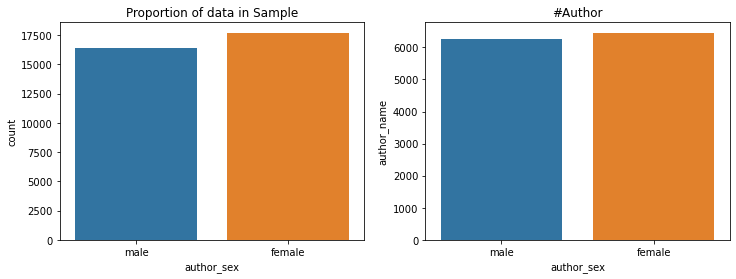

In [58]:
#1. Author Sex

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (12,4))

sns.countplot(data = data, x = 'author_sex', order = ['male','female'], ax = ax[0])
ax[0].set_title('Proportion of data in Sample')

sex = data[['author_name','author_sex']].drop_duplicates().groupby(by = 'author_sex').agg({'author_name':'count'}).reset_index()
sns.barplot(x = 'author_sex', y = 'author_name', data = sex, order = ['male','female'], ax = ax[1])
ax[1].set_title('#Author')

plt.show()

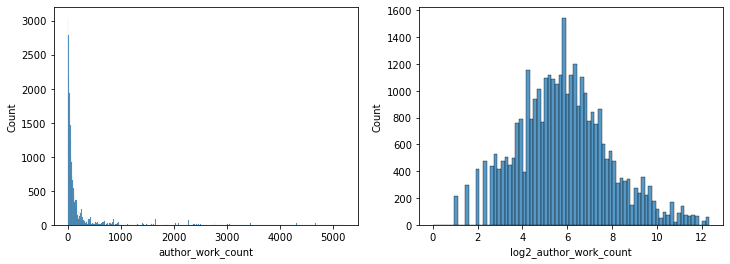

In [59]:
# Author Work Experience

data['log2_author_work_count'] = data['author_work_count'].apply(lambda x: math.log2(x+1))

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 4))
sns.histplot(data = data, x = 'author_work_count', ax = ax[0])
sns.histplot(data = data, x = 'log2_author_work_count', ax = ax[1])
plt.show()

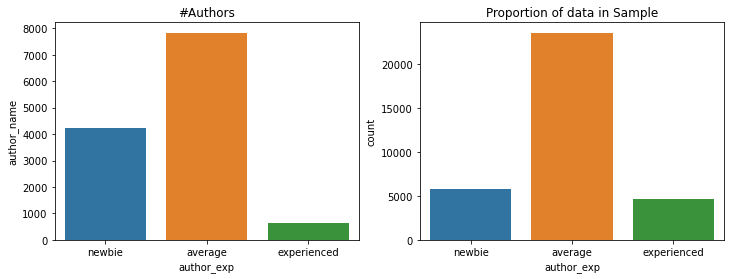

In [60]:
def classify_work_exp(x):
    if x < 4:
        return 'newbie'
    elif x >= 4 and x <= 8:
        return 'average'
    else:
        return 'experienced'
    
data['author_exp'] = data['log2_author_work_count'].apply(func = lambda x: classify_work_exp(x))

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (12,4))

exp = data[['author_name','author_exp']].drop_duplicates().groupby(by = 'author_exp').agg({'author_name':'count'}).reset_index()
sns.barplot(x = 'author_exp', y = 'author_name', data = exp, order = ['newbie', 'average', 'experienced'], ax =  ax[0])
ax[0].set_title('#Authors')

sns.countplot(data = data, x = 'author_exp', order = ['newbie', 'average', 'experienced'], ax = ax[1])
ax[1].set_title('Proportion of data in Sample')

plt.show()

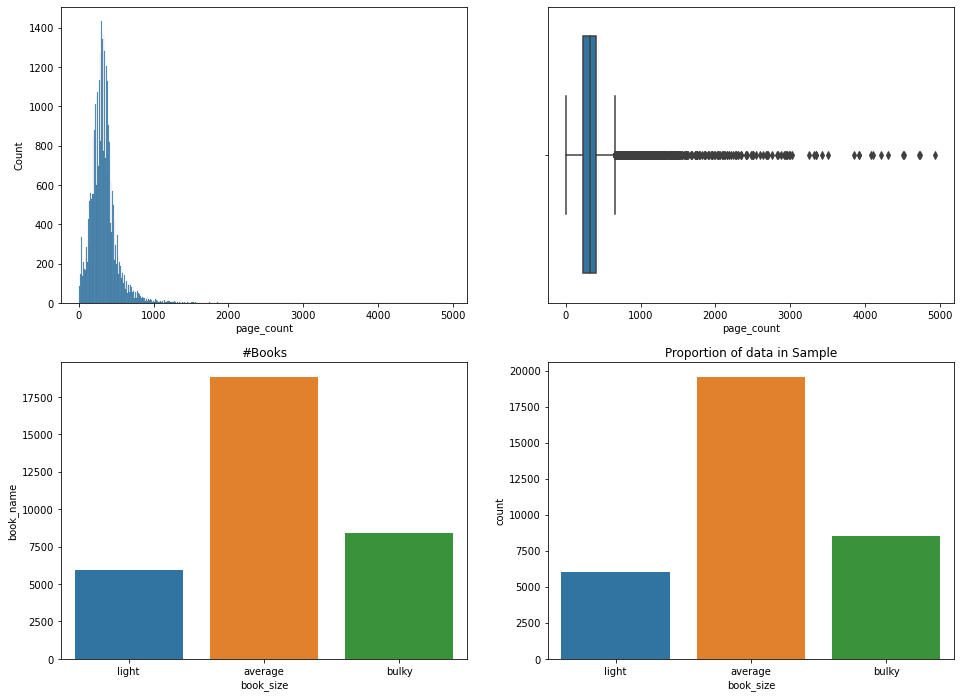

In [61]:
#3. Book Size

def classify_book_size(x):
    if x < 200:
        return 'light'
    elif x >= 200 and x <= 400:
        return 'average'
    else:
        return 'bulky'
    
data['book_size'] = data['page_count'].apply(func = lambda x: classify_book_size(x))

fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (16,12))

sns.histplot(data = data, x = 'page_count', ax = ax[0,0])
sns.boxplot(data = data, x = 'page_count', ax = ax[0,1])

size = data[['book_name','book_size']].drop_duplicates().groupby(by = 'book_size').agg({'book_name':'count'}).reset_index()
sns.barplot(x = 'book_size', y = 'book_name', data = size, order = ['light', 'average', 'bulky'], ax =  ax[1,0])
ax[1,0].set_title('#Books')

sns.countplot(data = data, x = 'book_size', order = ['light', 'average', 'bulky'], ax = ax[1,1])
ax[1,1].set_title('Proportion of data in Sample')

plt.show()

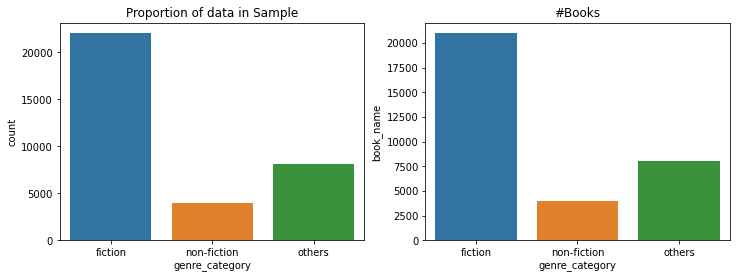

In [62]:
#4. Genre Mapping
genre = pd.read_csv('C:\\Users\\juhic\\OneDrive\\Desktop\\genre mapping.csv')
data_merged = pd.merge(left = data, right = genre, how = 'inner', on = 'genre')

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (12,4))

sns.countplot(data = data_merged, x = 'genre_category', order = ['fiction', 'non-fiction', 'others'], ax = ax[0])
ax[0].set_title('Proportion of data in Sample')

genre=data_merged[['book_name','genre_category']].drop_duplicates().groupby(by='genre_category').agg({'book_name':'count'}).reset_index()
sns.barplot(x = 'genre_category', y = 'book_name', data = genre, order = ['fiction', 'non-fiction', 'others'], ax = ax[1])
ax[1].set_title('#Books')
plt.show()

#### Data Download

In [63]:
data_merged.head()

,book_id,book_name,genre,page_count,is_volume,rating_count,author_name,author_sex,author_work_count,author_fan_count,author_rating_count,author_review_count,author_avg_rating,log2_author_work_count,author_exp,book_size,genre_category
0,630104,inner circle,young adult,220,yes,7597,kate brian,female,40,2192,182878,8604,3.93,5.357552,average,average,fiction
1,1783289,ambition,young adult,279,yes,6719,kate brian,female,40,2192,182878,8604,3.93,5.357552,average,average,fiction
2,2206960,revelation,young adult,249,yes,7431,kate brian,female,40,2192,182878,8604,3.93,5.357552,average,average,fiction
3,1783281,legacy,young adult,243,yes,7010,kate brian,female,40,2192,182878,8604,3.93,5.357552,average,average,fiction
4,7148778,vanished,young adult,204,yes,3724,kate brian,female,40,2192,182878,8604,3.93,5.357552,average,average,fiction


In [64]:
# Download merged dataset
data_merged.to_csv('C:\\Users\\juhic\\OneDrive\\Desktop\\master_dataset.csv')